# Package Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import lightgbm as lgb

from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap
from google.cloud import bigquery
from pandas_gbq import read_gbq
from google.oauth2 import service_account
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMClassifier

# %pip install google-cloud-bigquery
# %pip install db-dtypes
# %pip install google-cloud-bigquery-storage
# %pip install pandas-gbq

# Dataset Retrieval from BigQuery

In [2]:
#Get df from BigQuery
creds = service_account.Credentials.from_service_account_file("car-resale-capstone-81cd3a4d7939.json")
proj_id="car-resale-capstone"

# For ML Data (Blank Cells filled with Assumptions)
ml_df = read_gbq(
    "SELECT * FROM `car-resale-capstone.car_resale_bigquery.final_ml_data`",
    project_id=proj_id,
    credentials=creds,
)
print(ml_df.head())
#print(ml_df.dtypes)

Downloading: 100%|██████████|
                                                 URL          Brand  \
0  https://carro.co/sg/en/cars/kia/cerato/kia-cer...            Kia   
1  https://carro.co/sg/en/cars/honda/civic/honda-...          Honda   
2  https://www.motorist.sg/used-car/10253/mercede...  Mercedes-Benz   
3  https://www.motorist.sg/used-car/10202/honda-s...          Honda   
4  https://www.motorist.sg/used-car/10197/honda-c...          Honda   

                            Make     Price Registration_Date   Sold  \
0                 Cerato 1.6A EX   93888.0        2020-09-24   True   
1  Civic 1.5A VTEC Turbo Sunroof   83888.0        2017-07-18   True   
2                           280S   59800.0        1978-08-31   True   
3                    S2000 2.2 M  102800.0        2008-09-24   True   
4             CIVIC TYPE-R 2.0 M   99800.0        2009-12-23  False   

   Number_of_Previous_Owners  Mileage_km  Previous_COE      OMV  ...  \
0                          1       46268    

# Linear Regression

In [3]:
df = ml_df.copy()

#Take only first 3 words of Make, which are the most important and removes redundant information
df["Make3"] = (
    df["Make"]
    .fillna("")
    .astype(str)
    .str.split()
    .str[:3]
    .str.join(" ")
    .str.strip()
    .replace("", np.nan)
)
df = df.dropna(subset=["Make"])
df = df.drop(columns=["Make"])

#Transform Posted_Date
#Transform from dbdate to datetime
dt = pd.to_datetime(df["Posted_Date"], errors="coerce")
#Transform to integer
df["Posted_Date_Days"] = (dt - pd.Timestamp("1970-01-01")).dt.days.astype("Int64")
#Drop raw date columns 
#(Safe because we already have Vehicle_Age_Days for Registration_Date, COE_Left_Days for COE_Expiry_Date,
#And Scrape_Date is irrelevant to users using the price prediction)
df = df.drop(columns=["Posted_Date", "Registration_Date", "COE_Expiry_Date", "Scrape_Date"], errors="ignore")

#Transform boolean to integer
for c in df.select_dtypes(include=["boolean","bool"]).columns:
    df[c] = df[c].astype(int)

#Remove columns that users/we cannot fill in 
drop_cols = [c for c in ["URL", "Sold"] if c in df.columns]
df = df.drop(columns=drop_cols, errors="ignore")
pd.set_option('display.max_columns', None)

print(df.head())


           Brand     Price  Number_of_Previous_Owners  Mileage_km  \
0            Kia   93888.0                          1       46268   
1          Honda   83888.0                          1       70892   
2  Mercedes-Benz   59800.0                          3       90456   
3          Honda  102800.0                          6      152159   
4          Honda   99800.0                          5      168671   

   Previous_COE      OMV  Road_Tax_Payable Transmission Fuel_Type  \
0       32699.0  14619.0               724    Automatic    Petrol   
1       49802.0  26873.0               684    Automatic    Petrol   
2       23672.0      0.0               280    Automatic    Petrol   
3       33377.0  35251.0               871       Manual    Petrol   
4       39313.0  34900.0               871       Manual    Petrol   

   Engine_Capacity_cc  Horse_Power_kW  Vehicle_Age_Years  Vehicle_Age_Days  \
0                1591              93                  5              1874   
1             

In [4]:
#One Hot Encoding for categorical columns as Linear Regression needs all numeric  
obj_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
df = pd.get_dummies(df, columns=obj_cols, drop_first=True)

In [5]:
X = df.drop(columns=['Price'])
y = df['Price']

#80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Split remaining 80% into 60% train, 20% val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 of 80% = 20%
)

#Combine train and validation sets
X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

#Initialize and fit Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_final_train, y_final_train)

#Align test set columns
X_test = X_test.reindex(columns=X_final_train.columns, fill_value=0)

#Predict on test set
test_predictions = linear_model.predict(X_test)

#Evaluate
test_r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

print(f'Test R²: {test_r2:.4f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test MAE: {test_mae:.2f}')

Test R²: 0.8637
Test RMSE: 52469.93
Test MAE: 19210.70


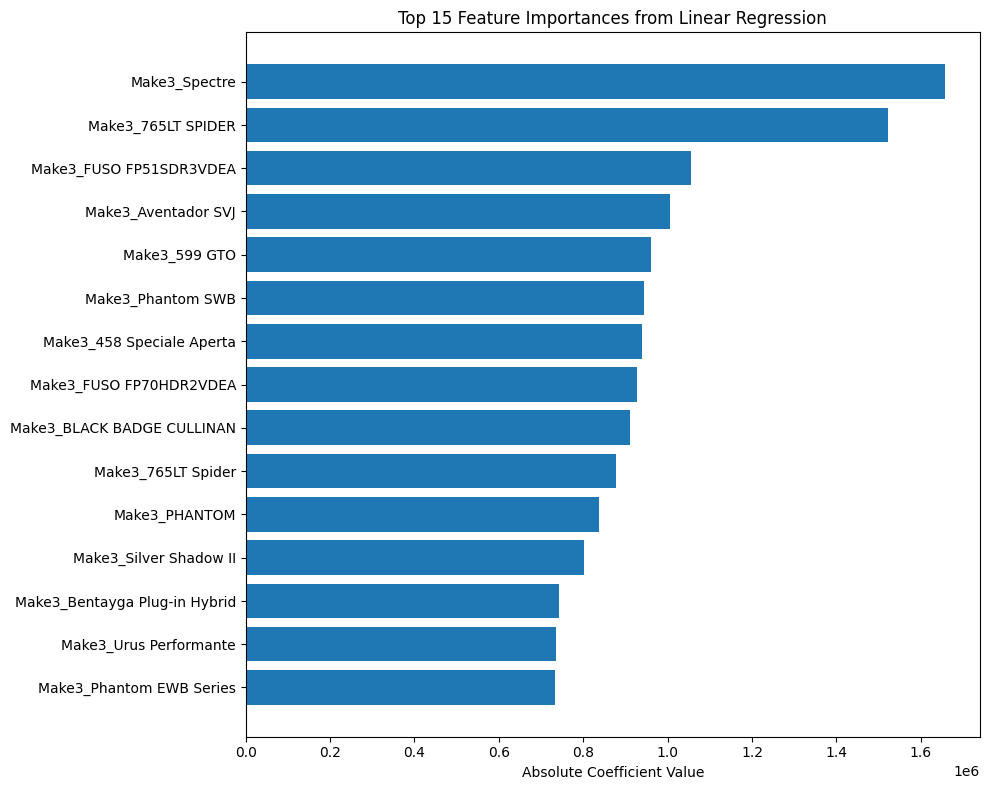

In [6]:
# Get coefficients
coefficients = linear_model.coef_

# Create DataFrame with absolute coefficient values
features_df_lr = pd.DataFrame({
    'Feature': X_final_train.columns,
    'Importance': np.abs(coefficients)  # take abs for comparison like RF
}).sort_values(by='Importance', ascending=False)

# Plot the top 15 features (styled like Random Forest plot)
plt.figure(figsize=(10, 8))
plt.barh(features_df_lr['Feature'].iloc[:15], features_df_lr['Importance'].iloc[:15])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 15 Feature Importances from Linear Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# LightBGM with ML Dataset

In [7]:
df = ml_df.copy()

#Take only first 3 words of Make, which are the most important and removes redundant information
df["Make3"] = (
    df["Make"]
    .fillna("")
    .astype(str)
    .str.split()
    .str[:3]
    .str.join(" ")
    .str.strip()
    .replace("", np.nan)
)
df = df.dropna(subset=["Make"])
df = df.drop(columns=["Make"])

#Transform Posted_Date
#Transform from dbdate to datetime
dt = pd.to_datetime(df["Posted_Date"], errors="coerce")
#Transform to integer
df["Posted_Date_Days"] = (dt - pd.Timestamp("1970-01-01")).dt.days.astype("Int64")
#Drop raw date columns (CatBoost can't use datetime dtypes)
#(Safe because we already have Vehicle_Age_Days for Registration_Date, COE_Left_Days for COE_Expiry_Date,
#And Scrape_Date is irrelevant to users using the price prediction)
df = df.drop(columns=["Posted_Date", "Registration_Date", "COE_Expiry_Date", "Scrape_Date"], errors="ignore")

for c in df.select_dtypes(include=["boolean","bool"]).columns:
    df[c] = df[c].astype(int)

#Remove columns that users / we cannot fill in 
drop_cols = [c for c in ["URL", "Sold"] if c in df.columns]
df = df.drop(columns=drop_cols, errors="ignore")
pd.set_option('display.max_columns', None)

print(df.head())

           Brand     Price  Number_of_Previous_Owners  Mileage_km  \
0            Kia   93888.0                          1       46268   
1          Honda   83888.0                          1       70892   
2  Mercedes-Benz   59800.0                          3       90456   
3          Honda  102800.0                          6      152159   
4          Honda   99800.0                          5      168671   

   Previous_COE      OMV  Road_Tax_Payable Transmission Fuel_Type  \
0       32699.0  14619.0               724    Automatic    Petrol   
1       49802.0  26873.0               684    Automatic    Petrol   
2       23672.0      0.0               280    Automatic    Petrol   
3       33377.0  35251.0               871       Manual    Petrol   
4       39313.0  34900.0               871       Manual    Petrol   

   Engine_Capacity_cc  Horse_Power_kW  Vehicle_Age_Years  Vehicle_Age_Days  \
0                1591              93                  5              1874   
1             

In [8]:
#Transform object to categorical 
obj_cols = df.select_dtypes(include=["object"]).columns
df[obj_cols] = (
    df[obj_cols]
    .astype("string")
    .fillna("Unknown")
    .astype("category")
)

In [9]:
# select_cols = ["OMV",
#                "Vehicle_Age_Days", 
#                "Horse_Power_kW", 
#                "Previous_COE", 
#                "COE_Left_Days", 
#                "Mileage_km",
#                "Engine_Capacity_cc",
#                "Brand",
#                "Road_Tax_Payable",
#                "Fuel_Type",
#                "Price"] 
# data = df[select_cols]

In [10]:
X = df.drop(columns=['Price'])
y = df['Price']

#Split into train+validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Split the train+validation set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

lgbm = lgb.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)]
)

#Retrain on Train+Val with best n_estimators
best_iter = lgbm.best_iteration_
lgbm_final = lgb.LGBMRegressor(
    n_estimators=best_iter,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
X_final_train = pd.concat([X_train, X_val], axis=0)
y_final_train = pd.concat([y_train, y_val], axis=0)
lgbm_final.fit(X_final_train, y_final_train)

#Evaluate on Test set
pred = lgbm_final.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)
print({"Test_R2": round(r2,4), "Test_RMSE": round(rmse,2), "Test_MAE": round(mae,2)})

r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mape = (abs((y_test - pred) / y_test).mean()) * 100

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4124
[LightGBM] [Info] Number of data points in the train set: 14871, number of used features: 28
[LightGBM] [Info] Start training from score 120752.634994
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 33721.1	valid_0's l2: 1.13711e+09
[400]	valid_0's rmse: 32221.2	valid_0's l2: 1.0382e+09
[600]	valid_0's rmse: 31970	valid_0's l2: 1.02208e+09
Early stopping, best iteration is:
[628]	valid_0's rmse: 31932.8	valid_0's l2: 1.0197e+09
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[L

In [11]:
r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mape = (abs((y_test - pred) / y_test).mean()) * 100

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")

R²: 0.9531
MAE: 10603.2384
RMSE: 30763.6970
MAPE: 10.4052%


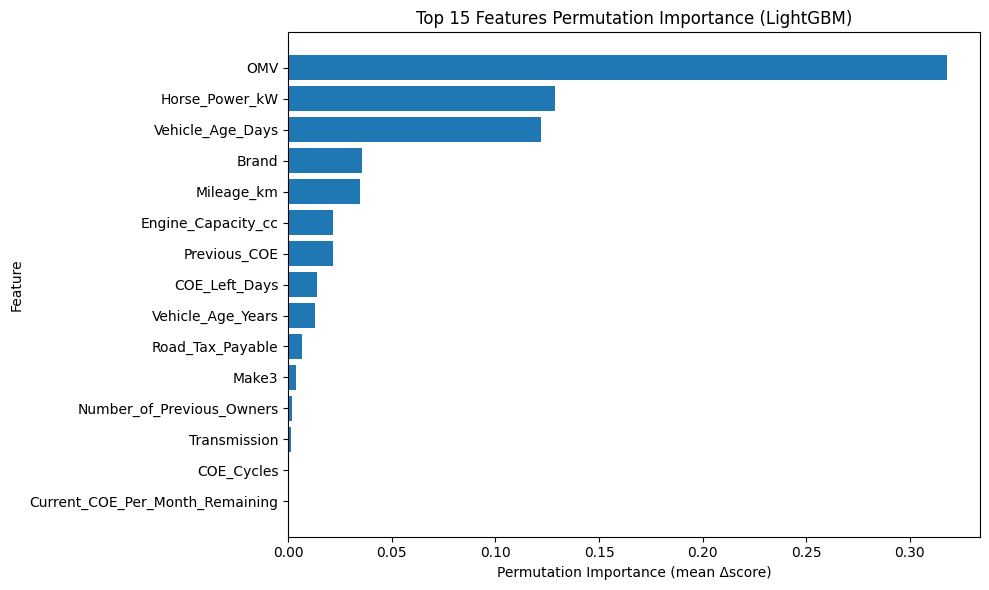

In [20]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

NUM = 15

# Permute inputs to the *pipeline* (raw X_*), measure drop in score
result = permutation_importance(
    lgbm_final, X_test, y_test,  # use your validation/holdout set
    n_repeats=10, random_state=42, n_jobs=-1
)

# Names must match X_valid columns (pre-preprocessing)
feature_names = getattr(X_test, 'columns', range(X_test.shape[1]))

perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

top = perm_df.head(NUM).iloc[::-1]
plt.figure(figsize=(10, 6))
plt.barh(top['Feature'], top['Importance'])
plt.xlabel('Permutation Importance (mean Δscore)')
plt.ylabel('Feature')
plt.title(f'Top {NUM} Features Permutation Importance (LightGBM)')
plt.tight_layout()
plt.show()


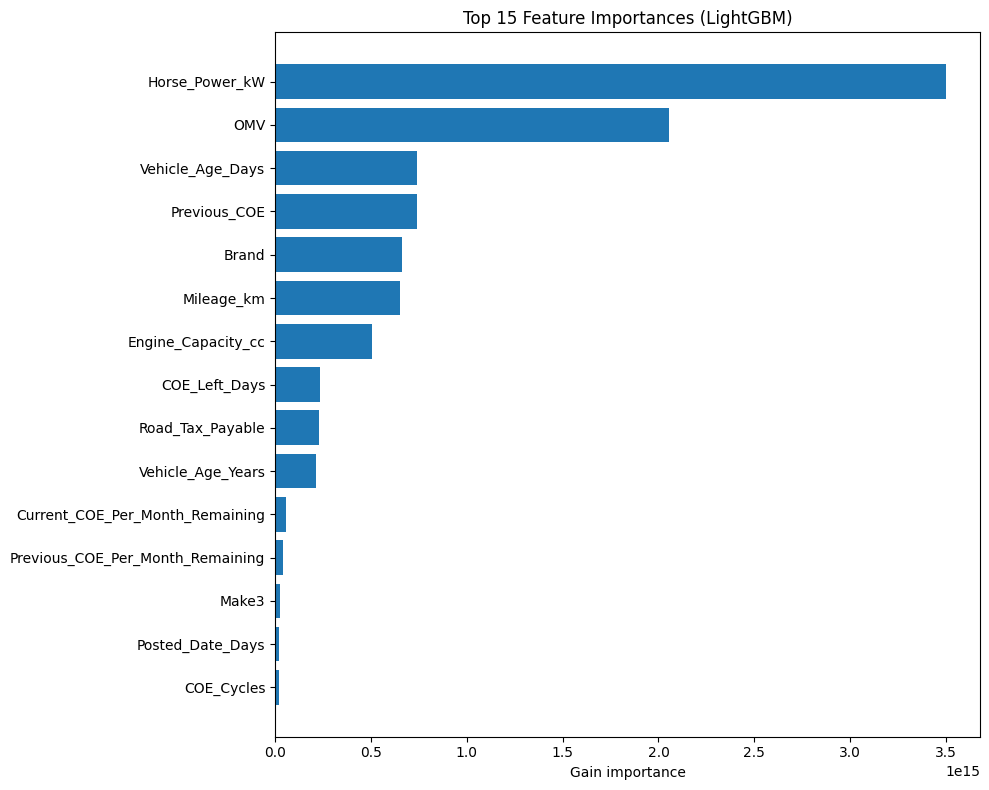

In [12]:
booster = lgbm_final.booster_
feat_names = lgbm_final.feature_name_
gain = booster.feature_importance(importance_type="gain")  # alternatives: "split", "gain"
features_df = (
    pd.DataFrame({"Feature": feat_names, "Importance": gain})
    .sort_values("Importance", ascending=False)
)

topk = 15
plt.figure(figsize=(10, 8))
plt.barh(features_df["Feature"].head(topk)[::-1], features_df["Importance"].head(topk)[::-1])
plt.xlabel("Gain importance")
plt.title(f"Top {topk} Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

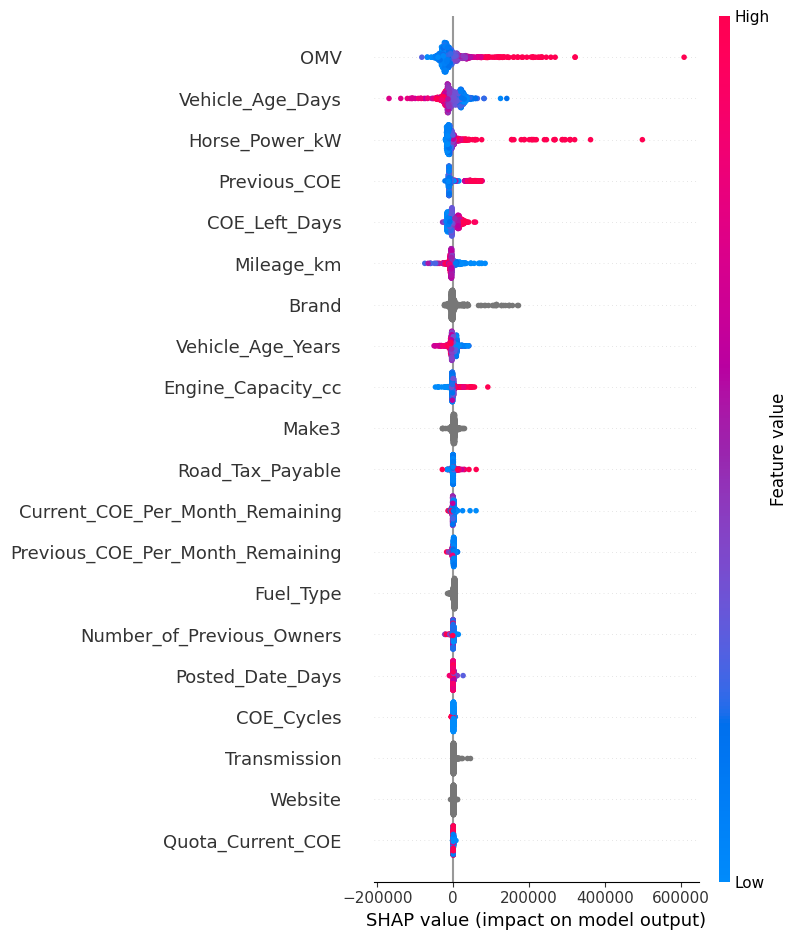

In [13]:
X_explain = X_test.sample(n=min(1000, len(X_test)), random_state=42)

explainer = shap.TreeExplainer(
    lgbm_final,
    feature_perturbation="tree_path_dependent",
    model_output="raw"
)

#Compute SHAP values
shap_values = explainer.shap_values(X_explain)

#Global importance (beeswarm)
shap.summary_plot(shap_values, X_explain, show=True)

# LightGBM with Dashboard Dataset (Lower R^2)

In [14]:
creds = service_account.Credentials.from_service_account_file("car-resale-capstone-81cd3a4d7939.json")
proj_id="car-resale-capstone"

# For Dashboard Data
dashboard_df = read_gbq(
    "SELECT * FROM `car-resale-capstone.car_resale_bigquery.final_dashboard_data`",
    project_id=proj_id,
    credentials=creds,
)
print(dashboard_df.head())

Downloading: 100%|██████████|
                                                 URL   Brand  \
0  https://carro.co/sg/en/cars/kia/cerato/kia-cer...     Kia   
1  https://carro.co/sg/en/cars/honda/civic/honda-...   Honda   
2  https://www.motorist.sg/used-car/10296/toyota-...  Toyota   
3  https://www.motorist.sg/used-car/10282/toyota-...  Toyota   
4  https://www.motorist.sg/used-car/10276/subaru-...  Subaru   

                              Make    Price Registration_Date   Sold  \
0                   Cerato 1.6A EX  93888.0        2020-09-24   True   
1    Civic 1.5A VTEC Turbo Sunroof  83888.0        2017-07-18   True   
2             MR-S 1.8 V-EDITION A  38800.0        2007-11-29  False   
3                        CELICA GT  49800.0        1992-05-21  False   
4  IMPREZA 5DR 2.5 STI AWD 6MT ABS  68800.0        2009-11-07  False   

   Number_of_Previous_Owners  Mileage_km  Previous_COE      OMV  \
0                          1     46268.0       32699.0  14619.0   
1                 

In [15]:
df = dashboard_df.copy()

#Take only first 3 words of Make, which are the most important and removes redundant information
df["Make3"] = (
    df["Make"]
    .fillna("")
    .astype(str)
    .str.split()
    .str[:3]
    .str.join(" ")
    .str.strip()
    .replace("", np.nan)
)
df = df.dropna(subset=["Make"])
df = df.drop(columns=["Make"])

#Transform Posted_Date
#Transform from dbdate to datetime
dt = pd.to_datetime(df["Posted_Date"], errors="coerce")
#Transform to integer
df["Posted_Date_Days"] = (dt - pd.Timestamp("1970-01-01")).dt.days.astype("Int64")
#Drop raw date columns (CatBoost can't use datetime dtypes)
#(Safe because we already have Vehicle_Age_Days for Registration_Date, COE_Left_Days for COE_Expiry_Date,
#And Scrape_Date is irrelevant to users using the price prediction)
df = df.drop(columns=["Posted_Date", "Registration_Date", "COE_Expiry_Date", "Scrape_Date"], errors="ignore")

for c in df.select_dtypes(include=["boolean","bool"]).columns:
    df[c] = df[c].astype(int)

#Remove columns that users / we cannot fill in 
drop_cols = [c for c in ["URL", "Sold"] if c in df.columns]
df = df.drop(columns=drop_cols, errors="ignore")
pd.set_option('display.max_columns', None)

print(df.head())

    Brand    Price  Number_of_Previous_Owners  Mileage_km  Previous_COE  \
0     Kia  93888.0                          1     46268.0       32699.0   
1   Honda  83888.0                          1     70892.0       49802.0   
2  Toyota  38800.0                          6         NaN       50168.0   
3  Toyota  49800.0                          6         NaN       33018.0   
4  Subaru  68800.0                          6         NaN       37502.0   

       OMV  Road_Tax_Payable Transmission Fuel_Type  Engine_Capacity_cc  \
0  14619.0             724.0    Automatic    Petrol                1591   
1  26873.0             684.0    Automatic    Petrol                1498   
2  24383.0               NaN    Automatic    Petrol                1794   
3  32992.0               NaN       Manual    Petrol                1998   
4  33249.0               NaN       Manual    Petrol                2457   

   Horse_Power_kW  Vehicle_Age_Years  Vehicle_Age_Days  COE_Left_Days  \
0            93.0        

In [16]:
#Transform object to categorical 
obj_cols = df.select_dtypes(include=["object"]).columns
df[obj_cols] = (
    df[obj_cols]
    .astype("string")
    .fillna("Unknown")
    .astype("category")
)

In [17]:
X = df.drop(columns=['Price'])
y = df['Price']

#Split into train+validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Split the train+validation set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

lgbm = lgb.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)]
)

#Retrain on Train+Val with best n_estimators
best_iter = lgbm.best_iteration_
lgbm_final = lgb.LGBMRegressor(
    n_estimators=best_iter,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
X_final_train = pd.concat([X_train, X_val], axis=0)
y_final_train = pd.concat([y_train, y_val], axis=0)
lgbm_final.fit(X_final_train, y_final_train)

#Evaluate on Test set
pred = lgbm_final.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)
print({"Test_R2": round(r2,4), "Test_RMSE": round(rmse,2), "Test_MAE": round(mae,2)})

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4122
[LightGBM] [Info] Number of data points in the train set: 14871, number of used features: 28
[LightGBM] [Info] Start training from score 119571.845202
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 30996.5	valid_0's l2: 9.60785e+08
[400]	valid_0's rmse: 30860.5	valid_0's l2: 9.5237e+08
Early stopping, best iteration is:
[312]	valid_0's rmse: 30670.6	valid_0's l2: 9.40685e+08
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin 

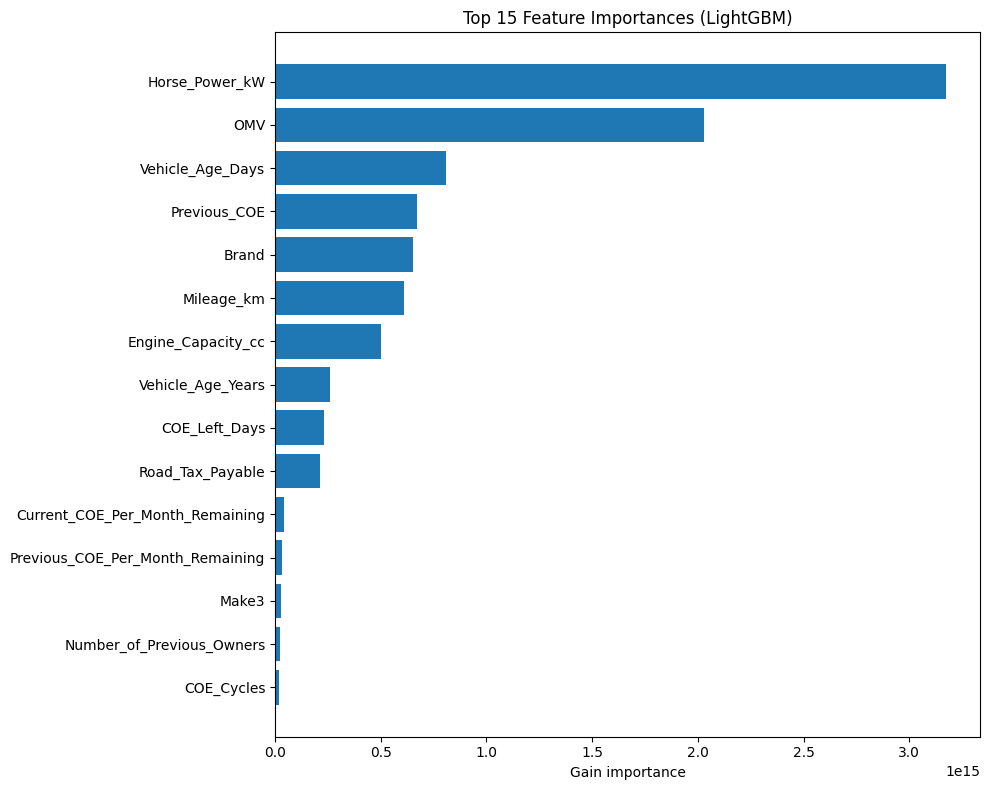

In [18]:
booster = lgbm_final.booster_
feat_names = lgbm_final.feature_name_
gain = booster.feature_importance(importance_type="gain")  # alternatives: "split", "gain"
features_df = (
    pd.DataFrame({"Feature": feat_names, "Importance": gain})
    .sort_values("Importance", ascending=False)
)

topk = 15
plt.figure(figsize=(10, 8))
plt.barh(features_df["Feature"].head(topk)[::-1], features_df["Importance"].head(topk)[::-1])
plt.xlabel("Gain importance")
plt.title(f"Top {topk} Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

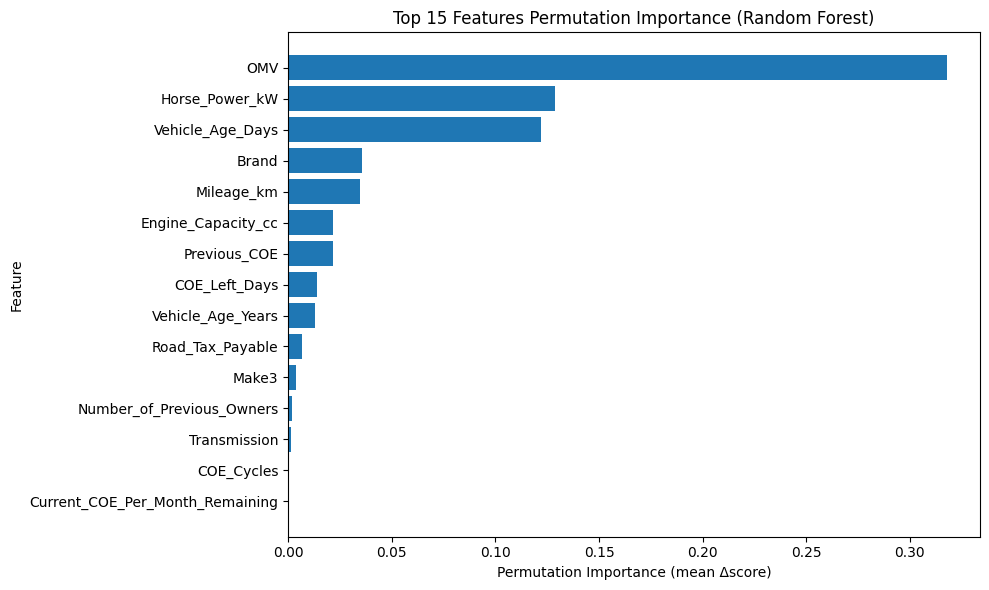

In [19]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

NUM = 15

# Permute inputs to the *pipeline* (raw X_*), measure drop in score
result = permutation_importance(
    lgbm_final, X_test, y_test,  # use your validation/holdout set
    n_repeats=10, random_state=42, n_jobs=-1
)

# Names must match X_valid columns (pre-preprocessing)
feature_names = getattr(X_test, 'columns', range(X_test.shape[1]))

perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

top = perm_df.head(NUM).iloc[::-1]
plt.figure(figsize=(10, 6))
plt.barh(top['Feature'], top['Importance'])
plt.xlabel('Permutation Importance (mean Δscore)')
plt.ylabel('Feature')
plt.title(f'Top {NUM} Features Permutation Importance (Random Forest)')
plt.tight_layout()
plt.show()


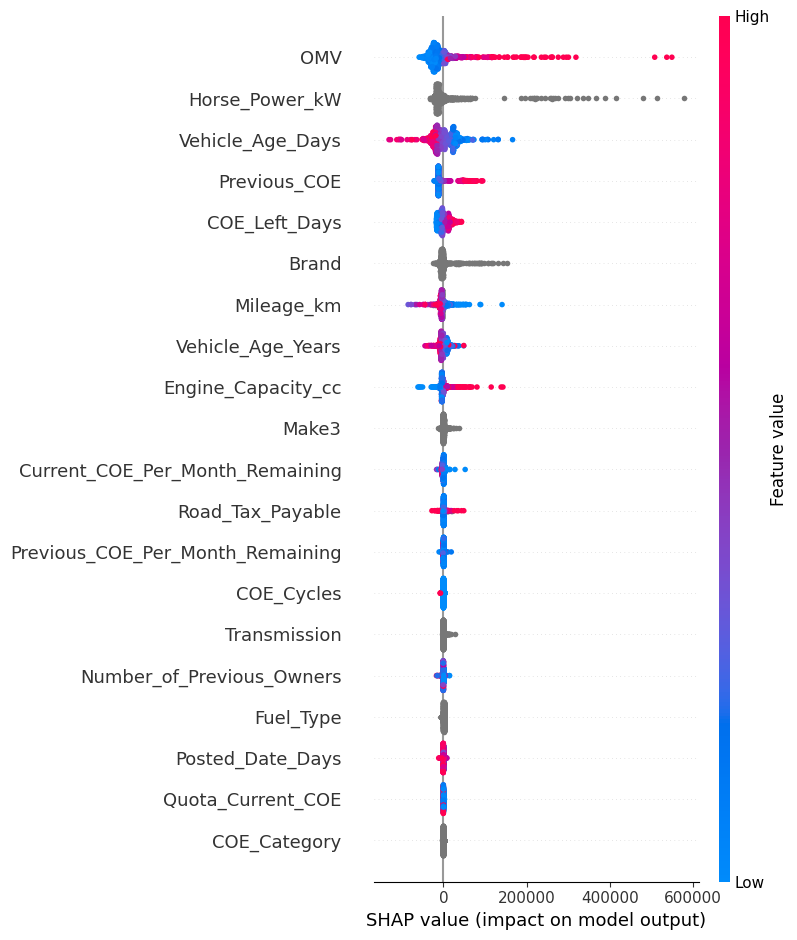

In [ ]:
X_explain = X_test.sample(n=min(1000, len(X_test)), random_state=42)

explainer = shap.TreeExplainer(
    lgbm_final,
    feature_perturbation="tree_path_dependent",
    model_output="raw"
)

#Compute SHAP values
shap_values = explainer.shap_values(X_explain)

#Global importance (beeswarm)
shap.summary_plot(shap_values, X_explain, show=True)